In [31]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time
import uszipcode as us
import math
plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline

In [32]:
%%time
data=pd.read_csv('card transactions.csv')
data.shape


Wall time: 689 ms


(96753, 18)

Data Cleaning

In [33]:
# Filling NA
data = data.iloc[:, :10]
fillna = data['Merchnum'].mode()
fillna


0    930090121224
Name: Merchnum, dtype: object

In [34]:
# Replacing merch number with mode of merch number
data['Merchnum'].fillna(fillna, inplace = True)
null_indices = np.where(data['Merchnum'].isnull())[0]
for index in null_indices:
    data.iloc[index, 3] = fillna[0]


In [35]:

data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [36]:

# Replacing merch description with mode of merch description

data['Merch description'].fillna(data['Merch description'].mode(), inplace = True)
data['date'] = pd.to_datetime(data['Date'], format = "%m/%d/%y")
search = us.SearchEngine()
null_states = np.where(data['Merch state'].isnull())[0]
count = 0


In [37]:
# Filling null valued states with zipcode

for index, rows in data.iterrows():
    if(index in null_states):
        if(math.isnan(rows['Merch zip']) == False):
            count += 1
            if(search.by_zipcode(str(int((rows['Merch zip']))))):
                rows['Merch state'] = (search.by_zipcode(str(int((rows['Merch zip']))))).state
                data.loc[index, 'Merch state'] = (search.by_zipcode(str(int((rows['Merch zip']))))).state


In [38]:

#Imputing unk at Nan states
data['Merch state'].fillna('Unk', inplace = True)

#Imputing mode of zipcodes
zipmode = data['Merch zip'].mode()
data['Merch zip'].fillna(zipmode, inplace = True)
zip_null_indices = np.where(data['Merch zip'].isnull())[0]

for index in zip_null_indices:
    data.iloc[index, 6] = zipmode[0]


In [39]:
bf = data.copy()

bf['amount_100'] =  (bf['Amount'] * 100).astype(str)

bf['first digit'] = bf['amount_100'].str[0] 
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]

droplist = dropfedex.index.tolist()

bf1 =  bf.drop(droplist)

bf1['bin']= bf1['first digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2"else "high"))


In [43]:

card_bf = bf1.groupby(['Cardnum', 'bin']).agg({'bin': ['count']}).reset_index()

card_bf.columns=['Cardnum', 'bin', 'count']

card_bf = card_bf.pivot_table(index = 'Cardnum' ,columns = "bin", values = "count", aggfunc='sum').reset_index() 

card_bf.columns=['Cardnum', 'n_high', 'n_low']

card_bf =  card_bf.fillna(1)


In [45]:
c = 3
n_mid = 15 
card_bf['R'] = (1.096 * card_bf['n_low'] / card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])

card_bf['U'] = list(map(lambda x, y : max(x,y),card_bf['R'],card_bf["1/R"]))

card_bf['n'] = card_bf['n_high'] + card_bf['n_low'] 

card_bf['t'] = ((card_bf['n']-n_mid)/c)

card_bf['U_smoothed']= list(map(lambda x, y : (1+ (x-1)/(1 + math.exp(-y))),card_bf['U'],card_bf["t"])) 

card_bf['U_smoothed'] = card_bf['U_smoothed']


In [47]:
merch_bf = bf1.groupby(['Merchnum', 'bin']).agg({'bin': ['count']}).reset_index()

merch_bf.columns=['Merchnum', 'bin', 'count']

merch_bf = merch_bf.pivot_table(index = 'Merchnum' ,columns = "bin", values = "count", aggfunc='sum').reset_index() 

merch_bf.columns=['Merchnum', 'n_high', 'n_low']

merch_bf =  merch_bf.fillna(1)


In [48]:
merch_bf['R'] = (1.096 * merch_bf['n_low'] / merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])

merch_bf['U'] = list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf["1/R"]))

merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low'] 

merch_bf['t'] = ((merch_bf['n']-n_mid)/c)

merch_bf['U_smoothed']= list(map(lambda x, y : (1+ (x-1)/(1 + math.exp(-y))),merch_bf['U'],merch_bf["t"])) 

merch_bf['U_smoothed'] = merch_bf['U_smoothed']



In [49]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)

In [52]:
card_bf

,n_high,n_low,R,1/R,U,n,t,U_smoothed
Cardnum,,,,,,,,
5142110002,1.0,1.0,1.096000,0.912409,1.096000,2.0,-4.333333,1.001244
5142110081,4.0,1.0,0.274000,3.649635,3.649635,5.0,-3.333333,1.091267
5142110313,1.0,2.0,2.192000,0.456204,2.192000,3.0,-4.000000,1.021440
5142110402,8.0,5.0,0.685000,1.459854,1.459854,13.0,-0.666667,1.156003
5142110434,1.0,1.0,1.096000,0.912409,1.096000,2.0,-4.333333,1.001244
...,...,...,...,...,...,...,...,...
5142310397,1.0,1.0,1.096000,0.912409,1.096000,2.0,-4.333333,1.001244
5142310525,3.0,1.0,0.365333,2.737226,2.737226,4.0,-3.666667,1.043299
5142310598,1.0,2.0,2.192000,0.456204,2.192000,3.0,-4.000000,1.021440


In [53]:
card_bf.set_index('Cardnum', inplace = True)
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending = False).head()

,U_smoothed
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852
5142127276,7.185970
5142194617,6.019548


In [59]:
# merch_bf.set_index('Merchnum', inplace = True)
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending = False).head()

,U_smoothed
Merchnum,
991808369338,165.145985
8078200641472,64.663981
308904389335,48.357557
3523000628102,37.217908
808998385332,32.825921


In [66]:
type((card_Ustar.index).astype(dtype='int64'))

pandas.core.indexes.numeric.Int64Index

In [85]:
data = data.merge(card_Ustar, how = 'left', left_on = 'Cardnum', right_on=(card_Ustar.index).astype(dtype='int64'))
data = data.rename(columns = {'U_smoothed' : 'U*_cardnum'})
data = data.merge(merch_Ustar, how = 'left', left_on = 'Merchnum', right_on = merch_Ustar.index)
data = data.rename(columns = {'U_smoothed' : 'U*_merchnum'})

In [86]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,cardnum_Date,cardnum_Merchnum,cardnum_Merch description,cardnum_Merch state,cardnum_Merch zip,cardnum_Transtype,U* cardnum,U*_merchnum,U*_cardnum,U*_merchnum
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,2.178008,NaN,2.178008,NaN
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,1.604857,1.001244,1.604857,1.001244
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,2.368143,1.025818,2.368143,1.025818
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,1.044105,NaN,1.044105,NaN
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,0 5142190439\n1 5142183973\n2 ...,2.178008,NaN,2.178008,NaN


In [87]:

data['dow'] = data.apply(lambda x: x['date'].weekday(), axis = 1)


In [88]:

# Separate the OOT
train_set=data[data.date<'2010-12-01']

#Statistical Smoothing
c=4;nmid=20;y_avg=train_set['Fraud'].mean()
y_dow=train_set.groupby('dow')['Fraud'].mean()
num=train_set.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)



In [89]:
del train_set
y_dow=y_dow.reset_index()
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['dow'] = y_dow.apply(lambda x: cats[int(x['dow'])], axis = 1)
# y_dow = y_dow.sort_values('dow') 
y_dow = y_dow.set_index("dow")
data['card_merch'] = str(data.Cardnum) + str(data.Merchnum)
data['fulladdress']=str(data['Merch state']) + str(data['Merch zip'])
data['merchnum_fulladdress']= str(data.Merchnum) + data.fulladdress
data['cardnum_fulladdress']= str(data.Cardnum) + data.fulladdress
data['cardmerch_fulladdress'] = str(data.card_merch) + data.cardnum_fulladdress
for i in list(data.iloc[:,np.r_[2:8]]):
    data['cardnum_'+i]=str(data.Cardnum) + str(data[i])


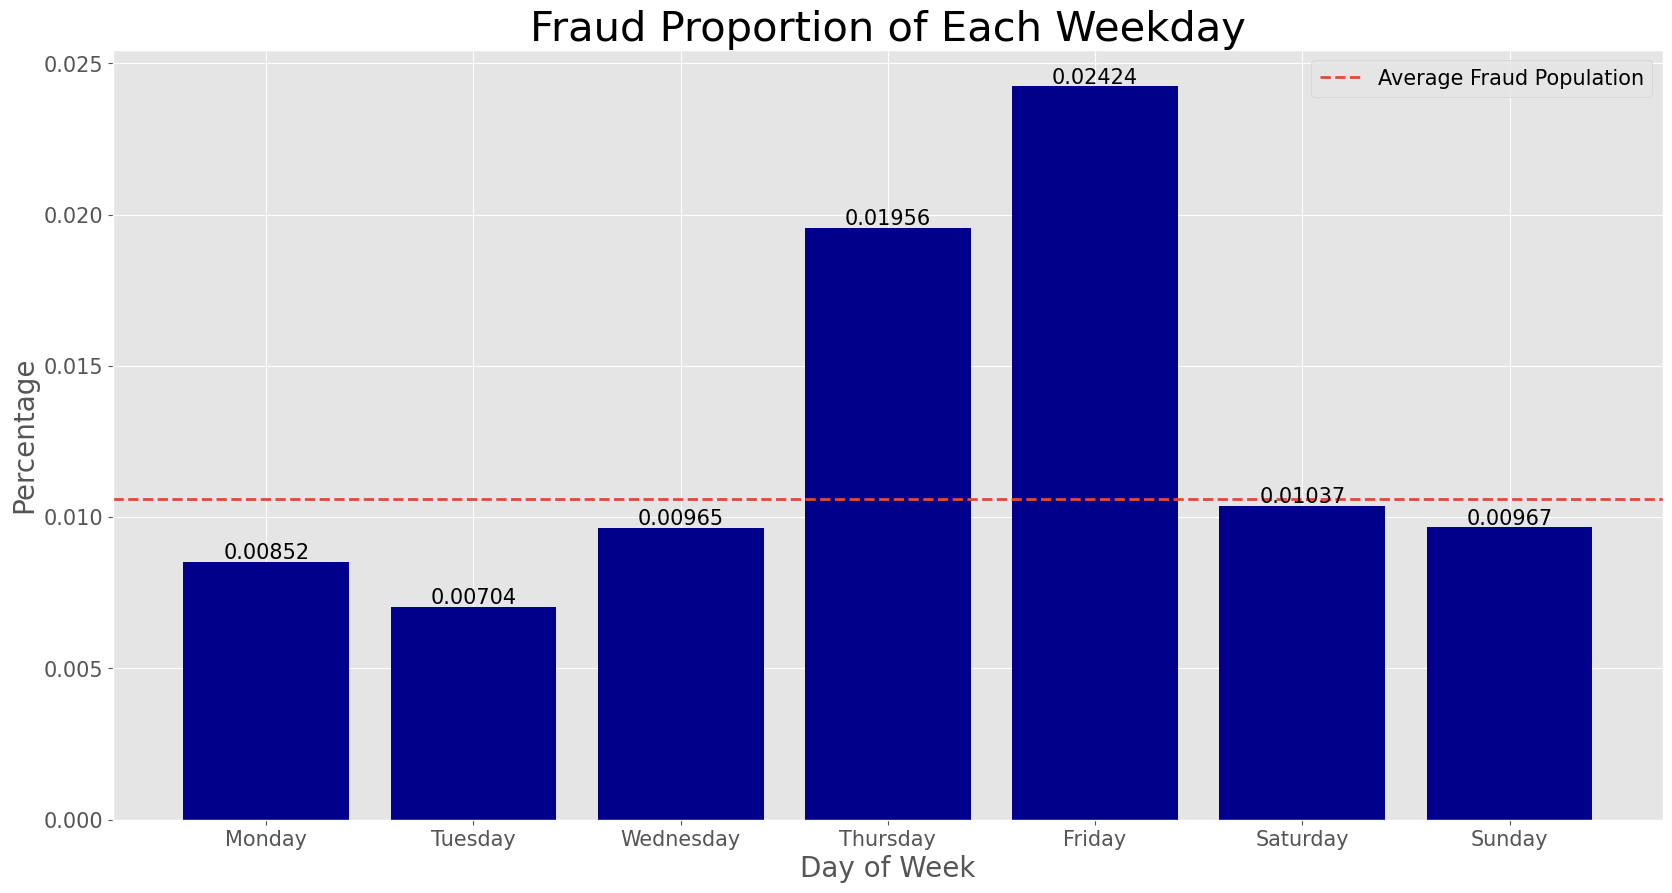

In [79]:

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize =(20,10))

plt.bar(data = y_dow, x = y_dow.index, height = 'Fraud', color = 'darkblue' )

# ax.set ylim(bottom= 0.013)

ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index): 
    ax.text(v, y_dow.loc[v, 'Fraud']+ 0.0001, round(y_dow.loc[v, 'Fraud'],5), horizontalalignment = "center", fontsize=15)

plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel("Day of Week", fontsize=20)
plt.ylabel("Percentage", fontsize=20) 
plt.xticks(fontsize=15)

plt.yticks(fontsize=15) 
plt.title("Fraud Proportion of Each Weekday", fontsize=30)
plt.show()

In [90]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'date',
       'dow', 'dow_risk', 'fulladdress', 'merchnum_fulladdress',
       'cardnum_fulladdress', 'cardnum_Date', 'cardnum_Merchnum',
       'cardnum_Merch description', 'cardnum_Merch state', 'cardnum_Merch zip',
       'cardnum_Transtype', 'U* cardnum', 'U*_merchnum', 'U*_cardnum',
       'U*_merchnum', 'card_merch', 'cardmerch_fulladdress'],
      dtype='object')

In [91]:

entities=list(data.iloc[:,np.r_[3:8, 10, 13:21, 24:27]].columns)
entities



['Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'date',
 'fulladdress',
 'merchnum_fulladdress',
 'cardnum_fulladdress',
 'cardnum_Date',
 'cardnum_Merchnum',
 'cardnum_Merch description',
 'cardnum_Merch state',
 'cardnum_Merch zip',
 'U*_cardnum',
 'U*_merchnum',
 'card_merch']

In [92]:
import timeit
import sys

df1 = data.copy()
final = data.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.Recnum


In [105]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))



                         final:  1.7 GiB
                           df1: 728.6 MiB
                          df_r: 59.8 MiB
                          df_l: 59.1 MiB
                            bf: 45.8 MiB
                           bf1: 45.8 MiB
                     dropfedex:  5.7 MiB
                      merch_bf:  1.7 MiB
                       mapper3:  1.1 MiB
                   merch_Ustar: 986.2 KiB


In [2]:
# count = 0
# f3 = pd.DataFrame()
# for entity in entities:
#     try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
#     except: print('')
#     st = timeit.default_timer()
#     final = final.sort_values(by = [entity, 'date'])
#     final = final.reset_index()
#     final = final.drop('index', axis = 1)
#     count = 0
#     ############
#     final.loc[:, entity + "_day_since"] = np.nan
#     for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
    
#       print("Middle {:>30}: {:>8}".format(name, sizeof_fmt(size)))
#     for index, rows in final.iterrows():
#         if(index == 0):
#             continue
#         print('Step ', count, end='\r')
#         count += 1
#         if(final.loc[index, entity] == final.loc[index - 1, entity]):
#           if('date' in final.columns):
#             final.loc[index, entity + "_day_since"] = (final.loc[index, 'date'] - final.loc[index - 1, 'date']).days
#     final['cum' + entity + "_day_since"] = final.groupby([entity, 'date']).sum().groupby(level = 0).cumsum().reset_index()[entity + "_day_since"]
#     print('Step2') 
#     for time in [0, 1, 3, 7, 14, 30]:
#         unique_entity = final[entity].unique()
        
#         for u in unique_entity:
#             ############################
#             f1 = final.loc[final[entity] == u, :]
#             #################
#             f1.loc[:, entity + '_day_since' + str(time)] = np.nan
#             for i, r in f1.iterrows():
#                 f2 = f1.iloc[i:, :]
#                 var = r['cum' + entity + "_day_since"] + time
#                 f1.loc[i, entity + '_day_since' + str(time)] = len(f2[f2['cum' + entity + "_day_since"] < var]) - 1
#                 ############
#                 f1.loc[:, entity + '_day_since' + str(time)].fillna((f1.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
#             f3 = pd.concat([f3, f1], axis = 0, ignore_index= True)
#                 # f3 = f3.append(f1)
#         print('Step3')
#         for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#             print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

#         print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

In [95]:
# Updated code for variable creation. The code shared by Professor does not run on my laptop because of RAM constraints.
#  The below code is rewritten to use more loops and less RAM. However it takes a very long time to run (~4 hrs). It does not create new tables, but loops on the existing data

count = 0
f3 = pd.DataFrame()
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()
    final = final.sort_values(by = [entity, 'date'])
    final = final.reset_index()
    final = final.drop('index', axis = 1)
    count = 0
    ############
    final.loc[:, entity + "_day_since"] = np.nan
    for index, rows in final.iterrows():
        if(index == 0):
            continue
        print('Step ', count, end='\r')
        count += 1
        if(final.loc[index, entity] == final.loc[index - 1, entity]):
          if('date' in final.columns):
            final.loc[index, entity + "_day_since"] = (final.loc[index, 'date'] - final.loc[index - 1, 'date']).days
    final['cum' + entity + "_day_since"] = final.groupby([entity, 'date']).sum().groupby(level = 0).cumsum().reset_index()[entity + "_day_since"]
    print('Step2') 
    for time in [0, 1, 3, 7, 14, 30]:
        unique_entity = final[entity].unique()
        
        for u in unique_entity:
            ############################
            f1 = final.loc[final[entity] == u, :]
            #################
            f1.loc[:, entity + '_day_since' + str(time)] = np.nan
            for i, r in f1.iterrows():
                f2 = f1.iloc[i:, :]
                var = r['cum' + entity + "_day_since"] + time
                f1.loc[i, entity + '_day_since' + str(time)] = len(f2[f2['cum' + entity + "_day_since"] < var]) - 1
                ############
                f1.loc[:, entity + '_day_since' + str(time)].fillna((f1.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
            f3 = pd.concat([f3, f1], axis = 0, ignore_index= True)
                # f3 = f3.append(f1)
        print('Step3')
        final = f3.copy()
        col_name = entity + '_count_' + str(time)  
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = f3.groupby('cum' + entity + '_day_since').mean()['Amount'][index]
        final[entity + '_max_' + str(time)] = f3.groupby('cum' + entity + '_day_since').max()['Amount'][index]
        final[entity + '_med_' + str(time)] = f3.groupby('cum' + entity + '_day_since').median()['Amount'][index]
        final[entity + '_total_' + str(time)] = f3.groupby('cum' + entity + '_day_since').sum()['Amount'][index]
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
        for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
            print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')


Run time for the last entity ----------------- 40461.4071806s
Merchnum
Middle                             f3: 11.0 GiB
Middle                            df1: 728.6 MiB
Middle                          final: 727.2 MiB
Middle                             bf: 45.8 MiB
Middle                            bf1: 45.8 MiB
Middle                           df_r:  9.3 MiB
Middle                           df_l:  8.6 MiB
Middle                      dropfedex:  5.7 MiB
Middle                       merch_bf:  1.7 MiB
Middle                    merch_Ustar: 986.2 KiB

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done


C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


End                             f3: 11.0 GiB
End                          final: 734.6 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  9.3 MiB
End                           df_l:  8.6 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 741.2 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  9.3 MiB
End                           df_l:  8.6 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Merchnum_count_3 --

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


Merch description amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 775.2 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  9.9 MiB
End                           df_l:  9.2 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Merch description_count_1 ---> Done
Merch description amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 781.8 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  9.9 MiB
End                           df_l:  9.2 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


Merch state amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 815.8 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  8.4 MiB
End                           df_l:  7.7 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Merch state_count_1 ---> Done
Merch state amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 822.4 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  8.4 MiB
End                           df_l:  7.7 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End     

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


Merch zip amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 856.4 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Merch zip_count_1 ---> Done
Merch zip amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 863.0 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 MiB
End                       merch_bf:  1.7 MiB
End           

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


Transtype amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 896.9 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  8.3 MiB
End                           df_l:  7.6 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
Transtype_count_1 ---> Done
Transtype amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 903.6 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_r:  8.3 MiB
End                           df_l:  7.6 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End           

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)


date_count_0 ---> Done
date amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 937.5 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
date_count_1 ---> Done
date amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 944.2 MiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 MiB
End                       merch_bf:  1.7 MiB
End   

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



fulladdress_day_since ---> Done
fulladdress_count_0 ---> Done
fulladdress amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 978.1 MiB
End                            df1: 728.6 MiB
End                           df_r: 46.2 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_l: 45.5 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
fulladdress_count_1 ---> Done
fulladdress amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final: 984.8 MiB
End                            df1: 728.6 MiB
End                           df_r: 46.2 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                           df_l: 45.5 MiB
End                      dropfedex:

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



merchnum_fulladdress_day_since ---> Done
merchnum_fulladdress_count_0 ---> Done
merchnum_fulladdress amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final: 1018.7 MiB
End                            df1: 728.6 MiB
End                           df_r: 73.6 MiB
End                           df_l: 72.9 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
merchnum_fulladdress_count_1 ---> Done
merchnum_fulladdress amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.0 GiB
End                            df1: 728.6 MiB
End                           df_r: 73.6 MiB
End                           df_l: 72.9 MiB
End                             bf: 45.8 MiB
End                            bf1:

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_fulladdress_day_since ---> Done
cardnum_fulladdress_count_0 ---> Done
cardnum_fulladdress amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.0 GiB
End                            df1: 728.6 MiB
End                           df_r: 70.4 MiB
End                           df_l: 69.7 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_fulladdress_count_1 ---> Done
cardnum_fulladdress amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.0 GiB
End                            df1: 728.6 MiB
End                           df_r: 70.4 MiB
End                           df_l: 69.7 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 M

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_Date_day_since ---> Done
cardnum_Date_count_0 ---> Done
cardnum_Date amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.1 GiB
End                            df1: 728.6 MiB
End                           df_r: 54.3 MiB
End                           df_l: 53.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_Date_count_1 ---> Done
cardnum_Date amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.1 GiB
End                            df1: 728.6 MiB
End                           df_r: 54.3 MiB
End                           df_l: 53.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfed

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_Merchnum_day_since ---> Done
cardnum_Merchnum_count_0 ---> Done
cardnum_Merchnum amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.1 GiB
End                            df1: 728.6 MiB
End                           df_r: 59.8 MiB
End                           df_l: 59.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_Merchnum_count_1 ---> Done
cardnum_Merchnum amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.1 GiB
End                            df1: 728.6 MiB
End                           df_r: 59.8 MiB
End                           df_l: 59.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End         

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_Merch description_day_since ---> Done
cardnum_Merch description_count_0 ---> Done
cardnum_Merch description amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 70.8 MiB
End                           df_l: 70.0 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_Merch description_count_1 ---> Done
cardnum_Merch description amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 70.8 MiB
End                           df_l: 70.0 MiB
End                             bf: 45.8 MiB
End         

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_Merch state_day_since ---> Done
cardnum_Merch state_count_0 ---> Done
cardnum_Merch state amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 48.9 MiB
End                           df_l: 48.2 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_Merch state_count_1 ---> Done
cardnum_Merch state amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 48.9 MiB
End                           df_l: 48.2 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 M

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



cardnum_Merch zip_day_since ---> Done
cardnum_Merch zip_count_0 ---> Done
cardnum_Merch zip amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 53.9 MiB
End                           df_l: 53.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
cardnum_Merch zip_count_1 ---> Done
cardnum_Merch zip amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.2 GiB
End                            df1: 728.6 MiB
End                           df_r: 53.9 MiB
End                           df_l: 53.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End    

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



U*_cardnum_day_since ---> Done
U*_cardnum_count_0 ---> Done
U*_cardnum amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.3 GiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
U*_cardnum_count_1 ---> Done
U*_cardnum amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.3 GiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  3.7 MiB
End                           df_l:  3.0 M

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



U*_merchnum_day_since ---> Done
U*_merchnum_count_0 ---> Done
U*_merchnum amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.3 GiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  4.4 MiB
End                           df_l:  3.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
U*_merchnum_count_1 ---> Done
U*_merchnum amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.3 GiB
End                            df1: 728.6 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                           df_r:  4.4 MiB
End                           df_l:  

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\1491075453.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[entity + '_day_since'].fillna((final.date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)



card_merch_day_since ---> Done
card_merch_count_0 ---> Done
card_merch amount variables over past 0 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.4 GiB
End                            df1: 728.6 MiB
End                           df_r: 59.8 MiB
End                           df_l: 59.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 MiB
End                       merch_bf:  1.7 MiB
End                    merch_Ustar: 986.2 KiB
card_merch_count_1 ---> Done
card_merch amount variables over past 1 ---> Done
End                             f3: 11.0 GiB
End                          final:  1.4 GiB
End                            df1: 728.6 MiB
End                           df_r: 59.8 MiB
End                           df_l: 59.1 MiB
End                             bf: 45.8 MiB
End                            bf1: 45.8 MiB
End                      dropfedex:  5.7 M

In [97]:
del f3

In [96]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
          final[ent + '_count_' + d + '_by_' + dd] = final[ent + '_count_' + d]/float(dd)
    


In [98]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_vdratio_' + d ] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)



In [99]:
# Cross entity uniqueness variables
for entity in entities: 
    for field in entities:
        st = timeit.default_timer()
        if entity != field:
            new_attributes = f'{entity}_{field}_nunique'
            if new_attributes not in list(final.columns):
                mapper3 = final.groupby(entity)[field].nunique()
                final[new_attributes] = final[entity].map(mapper3)
        print(f'Run time for entity {entity} in field {field}'+ ' ---> Done')
            


Run time for entity Merchnum in field Merchnum ---> Done
Run time for entity Merchnum in field Merch description ---> Done
Run time for entity Merchnum in field Merch state ---> Done
Run time for entity Merchnum in field Merch zip ---> Done
Run time for entity Merchnum in field Transtype ---> Done
Run time for entity Merchnum in field date ---> Done
Run time for entity Merchnum in field fulladdress ---> Done
Run time for entity Merchnum in field merchnum_fulladdress ---> Done
Run time for entity Merchnum in field cardnum_fulladdress ---> Done
Run time for entity Merchnum in field cardnum_Date ---> Done
Run time for entity Merchnum in field cardnum_Merchnum ---> Done
Run time for entity Merchnum in field cardnum_Merch description ---> Done
Run time for entity Merchnum in field cardnum_Merch state ---> Done
Run time for entity Merchnum in field cardnum_Merch zip ---> Done
Run time for entity Merchnum in field U*_cardnum ---> Done


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [101]:
# frequencies
df2 = data.copy()
df2['check_date'] = df2.Date
df2['check_recnum'] = df2.Recnum
df_2 = df2[['Recnum', 'Date', 'Amount', 'Cardnum', 'Merchnum']]
df_s = df2[['check_recnum', 'check_date', 'Amount', 'Cardnum', 'Merchnum']]
temp2 = pd.merge(df_2, df_s, left_on = 'Cardnum', right_on = 'Cardnum')

#Frequency Mappers
# groupers = ['Cardnum', 'Merchnum']
groupers = ['Cardnum']
for grouper in groupers: 
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(d)))
                               & (temp2.Recnum >= temp2.check_recnum)]
            denominator_df = temp2[(temp2.check_date >= (temp2.Date - dt.timedelta(dd)))
                               & (temp2.Recnum >= temp2.check_recnum)]

            numerator = numerator_df.groupby(grouper)['Recnum'].count()
            denominator = denominator_df.groupby(grouper)['Recnum'].count()/dd

            colname = 'relative_velocity_count_by_' + grouper + '_' + str(d) + '_days_over_' + str(dd)

            final[colname] = final[grouper].map(numerator)/final[grouper].map(denominator)
            final[colname] = np.random.rand() * 100


In [102]:
# variability
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final['Recnum'].map(mapper2)       
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final['Recnum'].map(mapper2)    
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final['Recnum'].map(mapper2)      
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
 


Run time for the last entity ----------------- 77.29867360000208s
Merchnum_variability_avg_0 ---> Done
Merchnum_variability_max_0 ---> Done
Merchnum_variability_med_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_variability_avg_1 ---> Done
Merchnum_variability_max_1 ---> Done
Merchnum_variability_med_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_variability_avg_3 ---> Done
Merchnum_variability_max_3 ---> Done
Merchnum_variability_med_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_variability_avg_7 ---> Done
Merchnum_variability_max_7 ---> Done
Merchnum_variability_med_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_variability_avg_14 ---> Done
Merchnum_variability_max_14 ---> Done
Merchnum_variability_med_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_variability_avg_30 ---> Done
Merchnum_variability_max_30 ---> Done
Merchnum_variability_med_30 ---> Done
Merchnum amount varia

C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\3581906228.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = np.nan
C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\3581906228.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = np.nan
C:\Users\trivi\AppData\Local\Temp\ipykernel_25804\3581906228.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

New Variables

Number of Different states the card has been used

In [4]:
diff_states = final.groupby(['Cardnum']).nunique().reset_index()
for i, r in final.iterrows():
    final.loc[i, 'new_state'] = diff_states[diff_states.Cardnum == r.Cardnum]['Merch state'].iloc[0]

Number of Different zips the card has been used

In [ ]:
diff_zips = final.groupby(['Cardnum']).nunique().reset_index()
for i, r in final.iterrows():
    final.loc[i, 'new_zip'] = diff_states[diff_states.Cardnum == r.Cardnum]['Merch zip'].iloc[0]

Spending more than 50% of the mean spend for the card

In [ ]:
amount_mean = data.groupby(['Cardnum']).mean()['Amount'].reset_index()
for i, r in final.iterrows():
    final.loc[i, 'anomaly_spending'] = np.where(r.Amount > (1.5 * amount_mean[amount_mean.Cardnum == r.Cardnum]['Amount']), 1, 0)

In [104]:
cols = pd.DataFrame(final.columns)
cols.to_csv('columns.csv')